# Sentiment Analysis
En este estudio se hace un análisis de sentimentos. Los datos a analizar son comentarios de Amazon, en que los clientes hicieron críticas positivas o negativas a una serie de productos.

El primer paso del estudio es cargar los paquetes a utilizar y ajustar algunos formatos para los outputs.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler

pd.set_option('display.float_format', lambda x: '%.3f' % x) # formato del output, 3 decimales
pd.set_option('display.max_columns', 20) # número máximo de columnas a mostrar en el terminal
pd.set_option('display.max_rows', 50) # número máximo de filas a mostrar en el terminal

Luego se cargan los datos y se hacen algunos análisis iniciales. Se observa que la base de datos tiene 10.000 observaciones (filas) y 2 variables (columnas). La variable **score** es la variable de respuesta, que toma un valor igual a 1 cuando la crítica es positiva y 0 cuando es negativa. Esta variable está balanceada, ya que el 51% de las observaciones son negativas y el 49% son positivas. Por otro lado, se verifica que el texto más largo contiene 1018 carácteres y el más corto contiene 104 carácteres.

In [38]:
dataset = pd.read_csv('amazon_reviews_sample.csv')
print('Dimensiones de los datos: \n', dataset.shape)
print(dataset.info())
print('Proporción Negativos/Positivos: \n', dataset['score'].value_counts(normalize=True))
print(dataset.head())

length_reviews = dataset.review.str.len()
print('Texto más largo: \n', max(length_reviews))
print('Texto más corto: \n', min(length_reviews))

Dimensiones de los datos: 
 (10000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   10000 non-null  int64 
 1   review  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None
Proporción Negativos/Positivos: 
 0   0.510
1   0.490
Name: score, dtype: float64
   score                                             review
0      1   Stuning even for the non-gamer: This sound tr...
1      1   The best soundtrack ever to anything.: I'm re...
2      1   Amazing!: This soundtrack is my favorite musi...
3      1   Excellent Soundtrack: I truly like this sound...
4      1   Remember, Pull Your Jaw Off The Floor After H...
Texto más largo: 
 1018
Texto más corto: 
 104


A continuación se hace un preprocesamiento a los datos para graficarlos. Se escribe una función que realiza los siguientes cambios en el texto:
- Transforma los strings a minúsuclas.
- Elimina los números del texto.
- Tokeniza, es decir, separa el texto en palabras individuales.
- Quita las Stopwords, usando la lista de wordcloud.
- Lematiza, es decir, reduce las palabras a su lema correspondiente.
- Vuelve a unir los tokens.

Esta función se aplica tanto a los textos negativos como positivos, por separado.

In [39]:
WNlemmatizer = WordNetLemmatizer()
def preprocess(s):
    s = s.lower()
    s = re.sub('[0-9]+', '', s) 
    tokens = nltk.tokenize.word_tokenize(s) 
    tokens = [t for t in tokens if t not in STOPWORDS] 
    tokens = [WNlemmatizer.lemmatize(token) for token in tokens]
    jtokens = ' '.join(tokens)
    return jtokens 

TextoP = dataset['review'][dataset['score']==1]
TextoN = dataset['review'][dataset['score']==0]

PTextoP = [preprocess(t) for t in TextoP]
PTextoN = [preprocess(t) for t in TextoN]

Luego se grafican los textos positivos. Destaca la palabra book, que probablemente no tiene mucha relación con la polaridad de los textos. También destacan palabras como good, great, well, excelent, que sí tienen una connotación positiva.

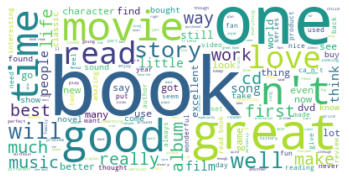

In [40]:
JP = ' '.join(PTextoP)
Positive_cloud = WordCloud(background_color="white").generate(JP)
plt.imshow(Positive_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Entre los textos negativos también destaca la palabra book. Asimismo, destaca good, que aparentemente no debería tener sentido que se encuentre en críticas negativas, a menos que se acompañe de not (not good). Esto sugiere que sería bueno utiliza n-grams en el análisis posterior.

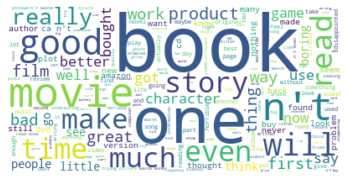

In [41]:
JN = ' '.join(PTextoN)
Negative_cloud = WordCloud(background_color="white").generate(JN)
plt.imshow(Negative_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

A continuación se procesan los textos usando la función definida anteriormente. Luego se crea la matriz de predictores usando el método de sklearn TfidfVectorizer. Se limita el número de features a 5000, se utilizan 1 y 2 n-grams, y se quitan las Stopwords usando la lista de sklearn.

In [42]:
Pdataset = [preprocess(t) for t in dataset.review]

# TfidfVectorizer
vect = TfidfVectorizer(max_features=5000, 
                       ngram_range=(1, 2), 
                       stop_words=ENGLISH_STOP_WORDS)
vect.fit(Pdataset)
X = vect.transform(Pdataset)
X = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
print(X.head())

abba  ability  able  able read  absolute  absolutely  absolutely love  \
0 0.000    0.000 0.000      0.000     0.000       0.000            0.000   
1 0.000    0.000 0.000      0.000     0.000       0.000            0.000   
2 0.000    0.000 0.000      0.000     0.000       0.111            0.000   
3 0.000    0.000 0.000      0.000     0.000       0.000            0.000   
4 0.000    0.000 0.000      0.000     0.000       0.000            0.000   

   absorbed  absurd  abuse  ...  youth  youtube    yr  yr old   zen  zero  \
0     0.000   0.000  0.000  ...  0.000    0.000 0.000   0.000 0.000 0.000   
1     0.000   0.000  0.000  ...  0.000    0.000 0.000   0.000 0.000 0.000   
2     0.000   0.000  0.000  ...  0.000    0.000 0.000   0.000 0.000 0.000   
3     0.000   0.000  0.000  ...  0.000    0.000 0.000   0.000 0.000 0.000   
4     0.000   0.000  0.000  ...  0.000    0.000 0.000   0.000 0.000 0.000   

   zero star  zeta  zeta jones  zombie  
0      0.000 0.000       0.000   0.000  
1

Luego se generan las variables X e y, donde *y* es la variable de respuesta y *X* es la matriz de predictores. Estas variables se separan en un grupo para entrenamiento y otro para testeo (20%).

In [43]:
# Train and Test sets
y = dataset['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

In [44]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (8000, 5000)
y_train shape:  (8000,)
X_test shape:  (2000, 5000)
y_test shape:  (2000,)


El primer modelo que se utiliza es **Naive Bayes** con sus parámetros predefinidos. El ajuste es rápido y bastante preciso.

In [45]:
# Naive Bayes X
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

Accuracy1 = model.score(X_test, y_test)
ROC_AUC1 = roc_auc_score(y_test, y_pred_proba)
F1Score1 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy1)
print("Area Under the ROC Curve:", ROC_AUC1)
print("F1 Score:", F1Score1)

Test accuracy of best CV params: 0.8305
Area Under the ROC Curve: 0.9189927563850548
F1 Score: 0.8262429523321374


Luego se ajusta una **regresión logística**. El ajuste es más lento, pero se obtienen resultados de gran precisión, algo mejores que en el caso de Naive Bayes. 

In [47]:
# Logistic Regression X
model = LogisticRegression(random_state=123)
parameters = {'C':[0.001, 0.01, 0.1, 1, 100, 1000], 
              'penalty':['l1', 'l2']}
searcher = GridSearchCV(estimator=model, 
                        param_grid=parameters, 
                        n_jobs=-1, 
                        verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
best_model = searcher.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]

Accuracy2 = searcher.score(X_test, y_test)
ROC_AUC2 = roc_auc_score(y_test, y_pred_proba)
F1Score2 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy2)
print("Area Under the ROC Curve:", ROC_AUC2)
print("F1 Score:", F1Score2)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.6min finished
Best CV params {'C': 1, 'penalty': 'l2'}
Test accuracy of best CV params: 0.841
Area Under the ROC Curve: 0.922711098706633
F1 Score: 0.8367556468172485


En la siguiente celda se resumen los resultados en un **cuadro**. Nuevamente se verifica que el mejor resultado se obtuvo con la combinación regresión logística. Sin embargo, hay que mencionar que las ganancias son marginales, por lo que si la velocidad de procesamiento es importante, podría ser más recomendable usar Naive Bayes.

In [53]:
Classifier = ['Naive Bayes', 'Logistic Regression']
Accuracy = [Accuracy1, Accuracy2]
ROC_AUC = [ROC_AUC1, ROC_AUC2]
F1Score = [F1Score1, F1Score2]

Resultados = pd.DataFrame({'Accuracy' : Accuracy, 
                           'ROC AUC' : ROC_AUC, 
                           'F1Score' : F1Score},
                           index=Classifier)
print(Resultados.idxmax())
Resultados

Accuracy    Logistic Regression
ROC AUC     Logistic Regression
F1Score     Logistic Regression
dtype: object


,Accuracy,ROC AUC,F1Score
Naive Bayes,0.831,0.919,0.826
Logistic Regression,0.841,0.923,0.837


Por último, se analizan los coeficientes con menos y mayor magnitud, que son los que determinan las predicciones negativas y positivas en mayor medida, respectivamente. En la mayoría de los casos tiene sentido que dichas palabras tengan un efecto negativo o positivo. Por ejemplo, la palabra más negativa fue 'dissapointed' y la más positiva fue 'great'.

In [55]:
# Logistic Regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

model = LogisticRegression(random_state=123, C=1, penalty='l2')
model.fit(X_train, y_train)

coeficientes =  pd.DataFrame(model.coef_, columns=X2_train.columns, index=['Coeficientes'])
coeficientes = coeficientes.T
coeficientes = coeficientes.sort_values('Coeficientes')
print(coeficientes.head(10))
print(coeficientes.tail(10))

Coeficientes
disappointed         -0.730
boring               -0.664
worst                -0.576
waste                -0.509
disappointing        -0.505
poor                 -0.492
terrible             -0.480
bad                  -0.474
money                -0.470
attempt              -0.452
                  Coeficientes
easy use                 0.428
highly recommend         0.443
wonderful                0.531
amazing                  0.555
awesome                  0.561
love                     0.567
perfect                  0.617
best                     0.645
excellent                0.764
great                    1.075


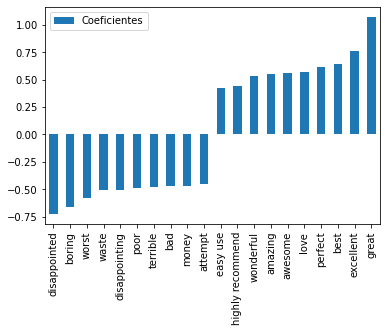

In [64]:
coef = pd.concat([coeficientes[:10], coeficientes[-10:]])
coef.plot.bar();